In [ ]:
#i used just one regular expression in the preprocessing data

In [1]:
years = list(range(2023, 2017, -1))
years 

[2023, 2022, 2021, 2020, 2019, 2018]

In [33]:
all_matches=[]

In [34]:
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"

In [35]:
from abc import ABC, abstractmethod
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

class Scraper(ABC):
    def __init__(self, standings_url, years):
        # Initialize the Scraper with a URL for standings and a list of years
        self.standings_url = standings_url
        self.years = years
        self.all_matches = []  # List to store scraped match data

    @abstractmethod
    def scrape_data(self):
        # Abstract method that must be implemented by subclasses
        pass

    def get_all_matches(self):
        # Return the list of all scraped match data
        return self.all_matches

class FootballScraper(Scraper):
    def __init__(self, standings_url, years):
        # Initialize FootballScraper by calling the superclass constructor
        super().__init__(standings_url, years)

    def scrape_data(self):
        # Iterate over each specified year
        for year in self.years:
            print(year)
            
            # Get standings page data
            data = requests.get(self.standings_url)
            soup = BeautifulSoup(data.text, 'html.parser')
            
            # Extract team URLs from the standings table
            standings_table = soup.select('table.stats_table')[0]
            links = [l.get("href") for l in standings_table.find_all('a')]
            links = [l for l in links if '/squads/' in l]
            team_urls = [f"https://fbref.com{l}" for l in links]

            # Update the standings URL to the previous season
            previous_season = soup.select("a.prev")[0].get("href")
            self.standings_url = f"https://fbref.com{previous_season}"

            # Iterate over each team URL
            for team_url in team_urls:
                team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
                
                # Get match and shooting data for the team
                data = requests.get(team_url)
                matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
                soup = BeautifulSoup(data.text, 'html.parser')
                links = [l.get("href") for l in soup.find_all('a')]
                links = [l for l in links if l and 'all_comps/shooting/' in l]
                data = requests.get(f"https://fbref.com{links[0]}")
                shooting = pd.read_html(data.text, match="Shooting")[0]
                shooting.columns = shooting.columns.droplevel()
                
                # Merge match and shooting data, filter by Premier League, and add season and team information
                try:
                    team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
                except ValueError:
                    continue
                team_data = team_data[team_data["Comp"] == "Premier League"]
                team_data["Season"] = year
                team_data["Team"] = team_name
                self.all_matches.append(team_data)
                time.sleep(5)

class DataPreparation:
    def __init__(self, all_matches):
        # Initialize DataPreparation with the list of all matches
        self.all_matches = all_matches

    def prepare_data(self):
        # Concatenating all matches into a single DataFrame
        prepared_data = pd.concat(self.all_matches, ignore_index=True)
        return prepared_data




In [38]:
football_scraper = FootballScraper(standings_url, years)
football_scraper.scrape_data()

2023
2022


In [ ]:
all_matches = football_scraper.get_all_matches()

In [39]:
data_preparation = DataPreparation(all_matches)
prepared_data = data_preparation.prepare_data()


In [371]:
import pandas as pd

# Load the CSV file into a variable
prepared_data = pd.read_csv("club_matches.csv")

# Display the first few rows of the DataFrame for verification
prepared_data = prepared_data.drop("Unnamed: 0", axis=1)

prepared_data


,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,pk,pkatt,fk,season,team
0,2023-08-13,16:30,Premier League,Matchweek 1,Sun,Away,D,1.0,1.0,Chelsea,...,Match Report,NaN,13.0,1.0,17.8,0,0,0.0,2023,Liverpool
1,2023-08-19,15:00,Premier League,Matchweek 2,Sat,Home,W,3.0,1.0,Bournemouth,...,Match Report,NaN,25.0,9.0,16.8,0,1,1.0,2023,Liverpool
2,2023-08-27,16:30,Premier League,Matchweek 3,Sun,Away,W,2.0,1.0,Newcastle Utd,...,Match Report,NaN,9.0,4.0,17.2,0,0,1.0,2023,Liverpool
3,2023-09-03,14:00,Premier League,Matchweek 4,Sun,Home,W,3.0,0.0,Aston Villa,...,Match Report,NaN,17.0,4.0,14.7,0,0,0.0,2023,Liverpool
4,2023-09-16,12:30,Premier League,Matchweek 5,Sat,Away,W,3.0,1.0,Wolves,...,Match Report,NaN,16.0,5.0,15.8,0,0,0.0,2023,Liverpool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4877,2018-04-15,16:00,Premier League,Matchweek 34,Sun,Away,W,1.0,0.0,Manchester Utd,...,Match Report,NaN,10.0,4.0,18.1,0,0,0.0,2017,West Bromwich Albion
4878,2018-04-21,12:30,Premier League,Matchweek 35,Sat,Home,D,2.0,2.0,Liverpool,...,Match Report,NaN,13.0,6.0,17.7,0,0,0.0,2017,West Bromwich Albion
4879,2018-04-28,15:00,Premier League,Matchweek 36,Sat,Away,W,1.0,0.0,Newcastle Utd,...,Match Report,NaN,9.0,2.0,20.1,0,0,0.0,2017,West Bromwich Albion
4880,2018-05-05,15:00,Premier League,Matchweek 37,Sat,Home,W,1.0,0.0,Tottenham,...,Match Report,NaN,9.0,1.0,10.2,0,0,0.0,2017,West Bromwich Albion


# Class for visualizing football match data

In [372]:
import matplotlib.pyplot as plt
import seaborn as sns

class FootballDataVisualizer:
    def __init__(self, match_df):
        self.match_df = match_df
        

    def visualize_count(self, column, title, x_label, y_label, rotation=45, hue=None):
        try:
            plt.figure(figsize=(10, 6))
            #Data Visualization by using Count Plot of library Seaborn ("pastel palette" refers to a set of colors that are soft)
            sns.countplot(x=column, data=self.match_df, palette="pastel", hue=hue)
            plt.title(title)
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            # Customize x-axis tick labels for better readability
            plt.xticks(rotation=rotation, ha='right')
            if hue:
                plt.legend(title=hue, bbox_to_anchor=(1, 1))
            plt.show()
        except Exception as e:
            print(f"Error during count plot visualization: {e}")     
    
    def visualize_pie_chart(self, column, title):
        plt.figure(figsize=(8, 8))
        column_distribution = self.match_df[column].value_counts()
        plt.pie(column_distribution, labels=column_distribution.index, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen', 'lightgrey'])
        plt.title(title)
        plt.show()
        
    def visualize_match_results_distribution(self):
        self.visualize_pie_chart('result', 'Match Results Distribution') 
    def visualize_venues(self):
        self.visualize_count('venue', 'Distribution of Venues', 'venue', 'Count')

    def visualize_match_count(self):
        self.visualize_count('team', 'Match Count by Team', 'team', 'Match Count')

    def visualize_win_loss_distribution(self):
        self.visualize_count('result', 'Win/Loss Distribution', 'result', 'Count', hue='team')
        
    def visualize_Number_of_Matches(self):
        self.visualize_count('round', 'Number of Matches in Each Round', 'round', 'Count')   


# Class for preprocessing football match data

In [373]:
import pandas as pd

class FootballDataPreprocessor:
    def __init__(self, matches):
        self.matches = matches

    def preprocess_data(self):
        # Feature engineering
        try:
            self.matches["date"] = pd.to_datetime(self.matches["date"])
            self.matches["target"] = (self.matches["result"] == "W").astype("int")
            self.matches["venue_code"] = self.matches["venue"].astype("category").cat.codes
            self.matches["opp_code"] = self.matches["opponent"].astype("category").cat.codes
            self.matches["hour"] = self.matches["time"].str.replace(":.+", "", regex=True).astype("int")
            self.matches["day_code"] = self.matches["date"].dt.dayofweek

        except KeyError as e:
            print(f"KeyError: {e}. The 'result' column may not be present in the DataFrame.")
        except Exception as e:
            print(f"Error during preprocessing: {e}")


# TestFootballDataPreprocessor

In [374]:
import unittest
import pandas as pd

sample_data = {
    'date': ['2022-01-01', '2022-01-02', '2022-01-03'],
    'time': ['15:00', '18:30', '20:15'],
    'comp': ['Premier League', 'Premier League', 'Premier League'],
    'round': ['Matchweek 1', 'Matchweek 2', 'Matchweek 1'],
    'day': ['Saturday', 'Sunday', 'Monday'],
    'venue': ['Home', 'Away', 'Home'],
    'result': ['Loss', 'Loss', 'Win'],
    'gf': [2, 1, 3],
    'ga': [1, 2, 0],
    'team': ['Arsenal', 'Liverpool', 'Watford'],
    'opponent': ['Arsenal', 'Liverpool', 'Watford'], 
    'xg': [1.5, 0.8, 2.0],
    'xga': [1.0, 1.2, 0.5],
    'poss': [55, 60, 65],
    'attendance': [25000, 30000, 28000],
    'captain': ['Player A', 'Player B', 'Player C'],
    'formation': ['4-4-2', '3-5-2', '4-3-3'],
    'referee': ['Referee X', 'Referee Y', 'Referee Z'],
    'match report': ['Link A', 'Link B', 'Link C'],
    'notes': ['Note 1', 'Note 2', 'Note 3'],
    'sh': [8, 5, 10],
    'sot': [4, 2, 7],
    'dist': [20, 15, 25],
    'pk': [1, 0, 2],
    'pkatt': [2, 0, 3],
    'fk': [5, 3, 6],
    'season': [2017, 2018, 2019],
}

prepared_sample_data = pd.DataFrame(sample_data)


class TestFootballDataPreprocessor(unittest.TestCase):
    def setUp(self):
        # Call the preprocess_data method
        self.preprocess = FootballDataPreprocessor(prepared_sample_data)
        self.preprocess.preprocess_data()
        name=self.shortDescription()


    def tearDown(self):
        print("end of test ",self.shortDescription())

    def test_target_column_exists(self):
        """target exist"""
        self.assertIn("target", self.preprocess.matches.columns, "Column 'target' not found.")

    def test_venue_code_column_exists(self):
        """venue code exist"""
        self.assertTrue("venue_code" in self.preprocess.matches.columns, "Column 'venue_code' not found.")

    def test_opp_code_column_exists(self):
        """opp_code exist"""
        self.assertTrue("opp_code" in self.preprocess.matches.columns, "Column 'opp_code' not found.")

    def test_hour_column_exists(self):
        """hour exist"""
        self.assertTrue("hour" in self.preprocess.matches.columns, "Column 'hour' not found.")

    def test_day_code_column_exists(self):
        """day_code exist"""
        self.assertTrue("day_code" in self.preprocess.matches.columns, "Column 'day_code' not found.")

    def test_target_column_type(self):
        """target type int32"""
        self.assertEqual(str(self.preprocess.matches["target"].dtype), "int32")

    def test_venue_code_column_type(self):
        """venue_code type int8"""
        self.assertEqual(str(self.preprocess.matches["venue_code"].dtype), "int8")

    def test_opp_code_column_type(self):
        """opp_code type int8"""
        self.assertEqual(str(self.preprocess.matches["opp_code"].dtype), "int8")

    def test_hour_column_type(self):
        """ hour type int32"""
        self.assertEqual(str(self.preprocess.matches["hour"].dtype), "int32")

    def test_hour_values_range(self):
        """hour between [0,24]"""
        self.assertTrue((self.preprocess.matches["hour"] >= 0).all() and (self.preprocess.matches["hour"] <= 24).all(), "Invalid values in 'hour' column.")

    def test_day_code_column_type(self):
        """day_code type int64"""
        self.assertEqual(self.preprocess.matches["day_code"].dtype, "int64")

def run_tests():
    loader = unittest.TestLoader()
    suite = loader.loadTestsFromTestCase(TestFootballDataPreprocessor)
    runner = unittest.TextTestRunner()
    result = runner.run(suite)

run_tests()

...........
----------------------------------------------------------------------
Ran 11 tests in 0.045s

OK


end of test  day_code exist
end of test  day_code type int64
end of test  hour exist
end of test  hour type int32
end of test  hour between [0,24]
end of test  opp_code exist
end of test  opp_code type int8
end of test  target exist
end of test  target type int32
end of test  venue code exist
end of test  venue_code type int8


In [375]:
prepared_sample_data

,date,time,comp,round,day,venue,result,gf,ga,team,...,dist,pk,pkatt,fk,season,target,venue_code,opp_code,hour,day_code
0,2022-01-01,15:00,Premier League,Matchweek 1,Saturday,Home,Loss,2,1,Arsenal,...,20,1,2,5,2017,0,1,0,15,5
1,2022-01-02,18:30,Premier League,Matchweek 2,Sunday,Away,Loss,1,2,Liverpool,...,15,0,0,3,2018,0,0,1,18,6
2,2022-01-03,20:15,Premier League,Matchweek 1,Monday,Home,Win,3,0,Watford,...,25,2,3,6,2019,0,1,2,20,0


# Class for modeling football match data

In [376]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class FootballDataModeler:
    def __init__(self, matches):
        self.matches = matches

    def train_model(self, predictors):
        try:
            # Check if 'predictors' and 'target' columns are present
                rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)
                train = self.matches[self.matches["date"] < '2021-01-01']
                rf.fit(train[predictors], train["target"])
                return rf
          
        except Exception as e:
            print(f"Error during model training: {e}")
            return None

    def evaluate_model(self, model, test_data, predictors):
        try:
            preds = model.predict(test_data[predictors])

            # Confusion Matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(confusion_matrix(test_data["target"], preds), annot=True, fmt='g', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()

            # Classification Report
            print("Classification Report:")
            print(classification_report(test_data["target"], preds))

            # Precision Score
            precision = precision_score(test_data["target"], preds)
            print(f"Precision Score: {precision}")

            return precision

        except Exception as e:
            print(f"Error during model evaluation: {e}")
            return None
           

In [380]:
# Step 1: Data Preprocessing
preprocessor = FootballDataPreprocessor(prepared_data)
preprocessor.preprocess_data()

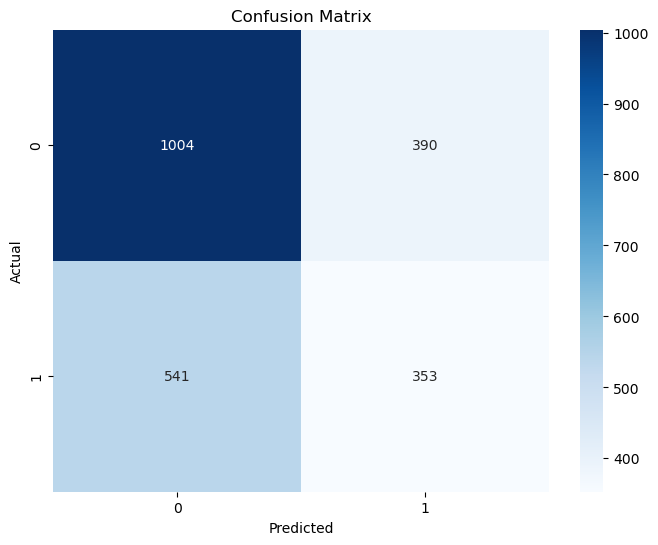

..
----------------------------------------------------------------------
Ran 2 tests in 0.368s

OK


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1394
           1       0.48      0.39      0.43       894

    accuracy                           0.59      2288
   macro avg       0.56      0.56      0.56      2288
weighted avg       0.58      0.59      0.58      2288

Precision Score: 0.47510094212651416
end of test  Evaluate_model Method
end of test  Train_model Method


In [378]:
import unittest
import matplotlib.pyplot as plt
import seaborn as sns

class TestFootballDataModeler(unittest.TestCase):
    def setUp(self):
        self.modeler = FootballDataModeler(prepared_data)
        name=self.shortDescription()

    def tearDown(self):
        # Clean up resources after each test
        plt.close()
        print("end of test ",self.shortDescription())

    def test_train_model(self):
        """Train_model Method"""
        # Get predictors and target
        predictors = ["venue_code", "opp_code", "hour", "day_code"]

        # Train the model
        model = self.modeler.train_model(predictors)

        # Check if the model is not None
        self.assertIsNotNone(model)

    def test_evaluate_model(self):
        """Evaluate_model Method"""
        # Get predictors and target
        predictors = ["venue_code", "opp_code", "hour", "day_code"]

        # Split the data into training and testing sets
        test_data = prepared_data[prepared_data["date"] > '2021-01-01']

        # Train the model
        model = self.modeler.train_model(predictors)

        # Check if the model is not None
        self.assertIsNotNone(model)

        # Evaluate the model
        precision = self.modeler.evaluate_model(model, test_data, predictors)

        # Add assertions for precision
        self.assertIsNotNone(precision)
        self.assertGreater(precision, 0.45, "Precision should be greater than 45%")
        self.assertTrue(0 <= precision <= 1, "Precision should be between 0 and 1")
        self.assertIsInstance(precision, float, "Precision should be of type float")


def run_tests():
    loader = unittest.TestLoader()
    suite = loader.loadTestsFromTestCase(TestFootballDataModeler)
    runner = unittest.TextTestRunner()
    result = runner.run(suite)

run_tests()


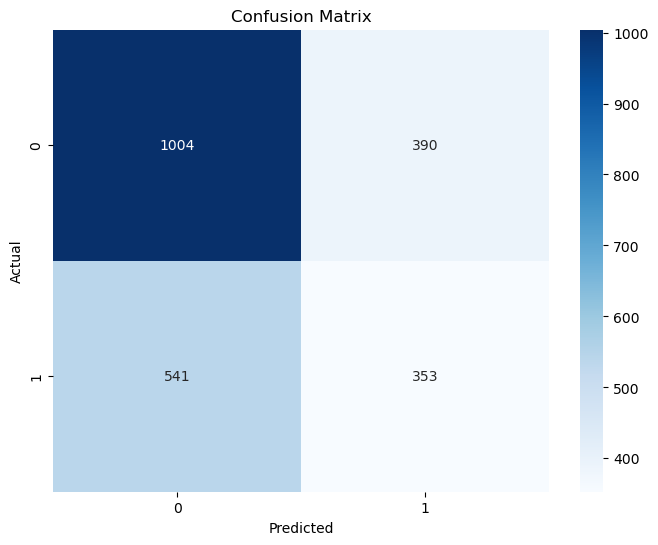

.
----------------------------------------------------------------------
Ran 1 test in 0.247s

OK


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1394
           1       0.48      0.39      0.43       894

    accuracy                           0.59      2288
   macro avg       0.56      0.56      0.56      2288
weighted avg       0.58      0.59      0.58      2288

Precision Score: 0.47510094212651416
End of test


In [379]:
import unittest
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, roc_curve, auc
import numpy as np  


class TestFootballDataModeler(unittest.TestCase):
    def setUp(self):
        self.modeler = FootballDataModeler(prepared_data)


    def tearDown(self):
        # Clean up resources after each test
        plt.close()
        print("End of test")

    def test_train_model(self):
        # Get predictors and target
        predictors = ["venue_code", "opp_code", "hour", "day_code"]
        target = "target"

        # Split the data into training and testing sets
        test_data = prepared_data[prepared_data["date"] > '2021-01-01']

        # Train the model
        model = self.modeler.train_model(predictors)

        # Check if the model is not None
        self.assertIsNotNone(model)

        # Evaluate the model
        precision = self.modeler.evaluate_model(model, test_data, predictors)

        # Add assertions for precision
        self.assertIsNotNone(precision)
        self.assertGreater(precision, 0.45, "Precision should be greater than 45%")
        self.assertTrue(0 <= precision <= 1, "Precision should be between 0 and 1")
        self.assertIsInstance(precision, float, "Precision should be of type float")






def run_tests():
    loader = unittest.TestLoader()
    suite = loader.loadTestsFromTestCase(TestFootballDataModeler)
    runner = unittest.TextTestRunner()
    result = runner.run(suite)

run_tests()


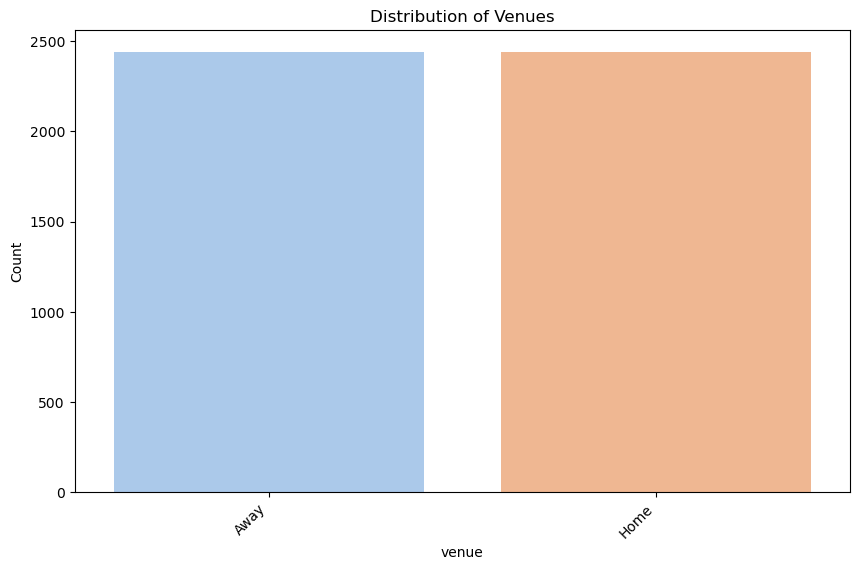

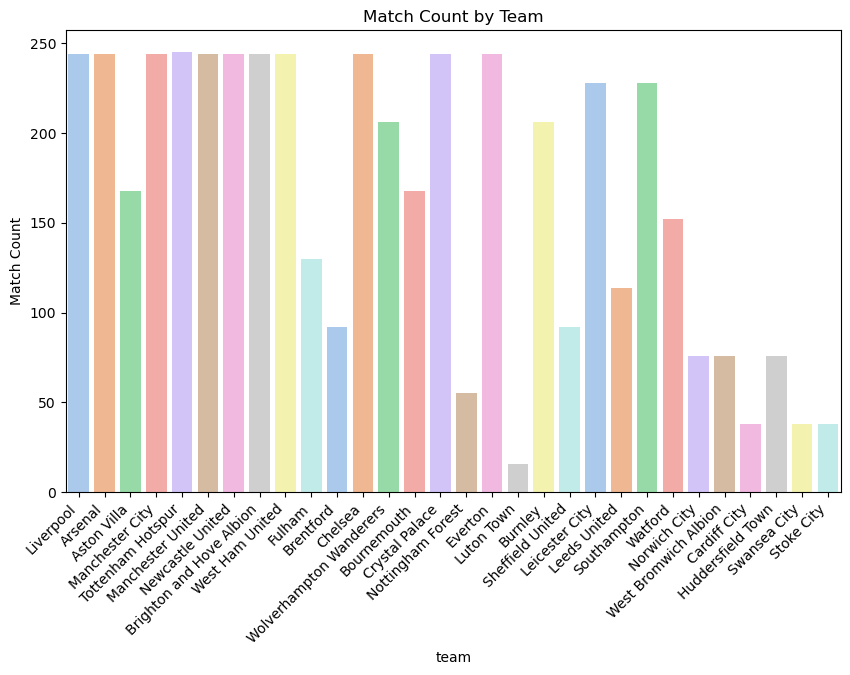

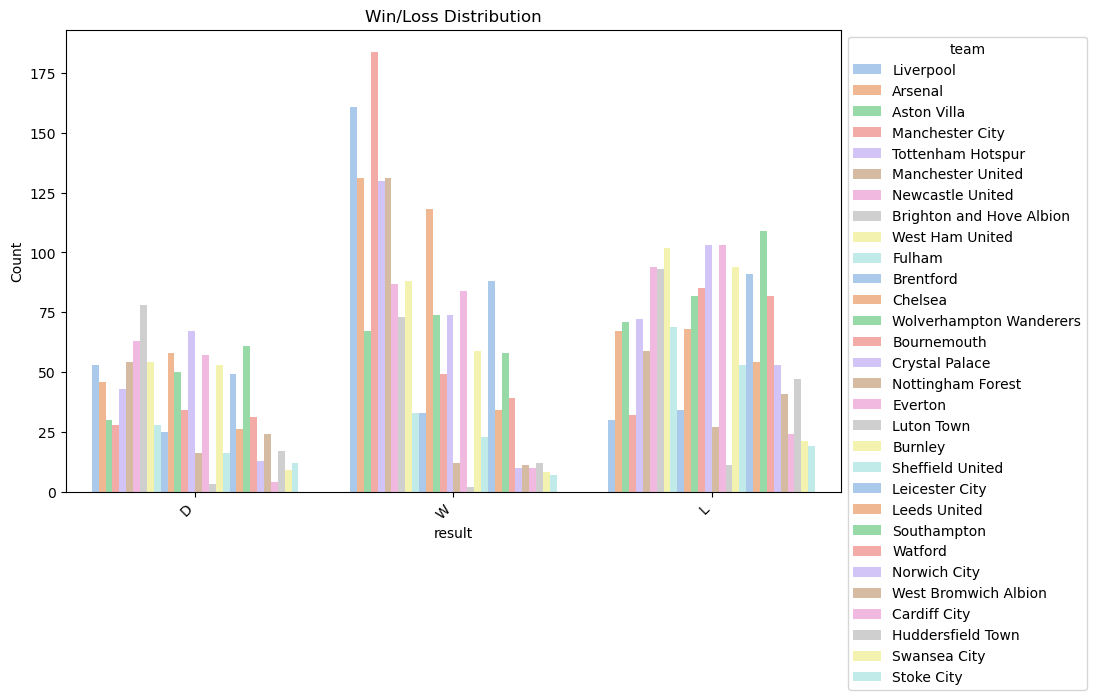

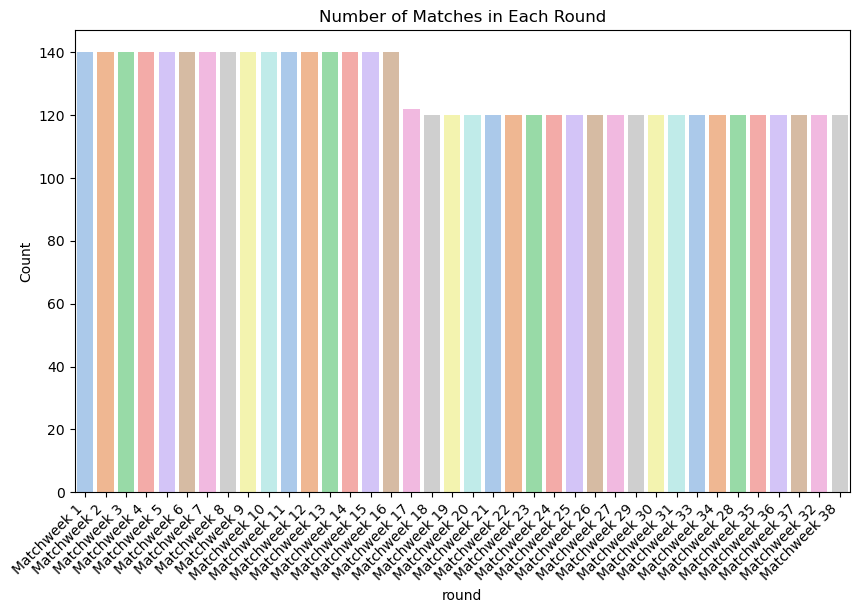

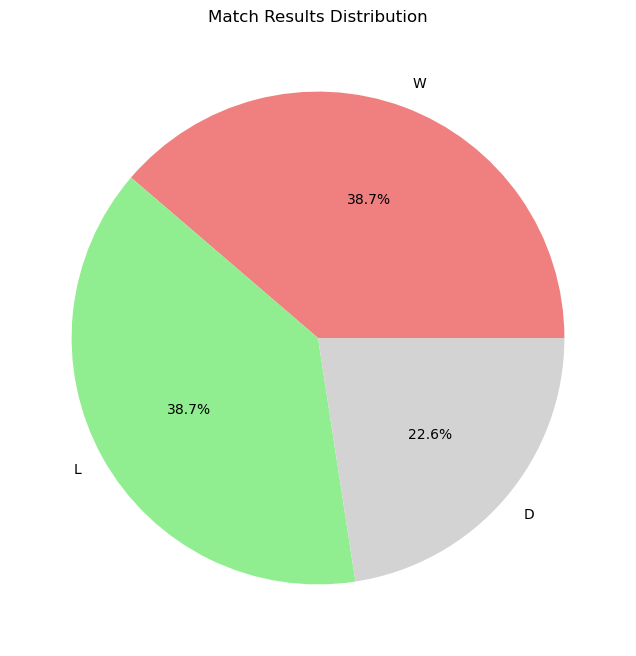

In [313]:
# Step 2: Data Visualization
visualizer = FootballDataVisualizer(prepared_data)
visualizer.visualize_venues()
visualizer.visualize_match_count()
visualizer.visualize_win_loss_distribution()
visualizer.visualize_Number_of_Matches()
visualizer.visualize_match_results_distribution()




In [314]:
# Step 3: Model Training
modeler = FootballDataModeler(prepared_data)
predictors = ["venue_code", "opp_code", "hour", "day_code"]
# Training the model
rf_model = modeler.train_model(predictors)
rf_model

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

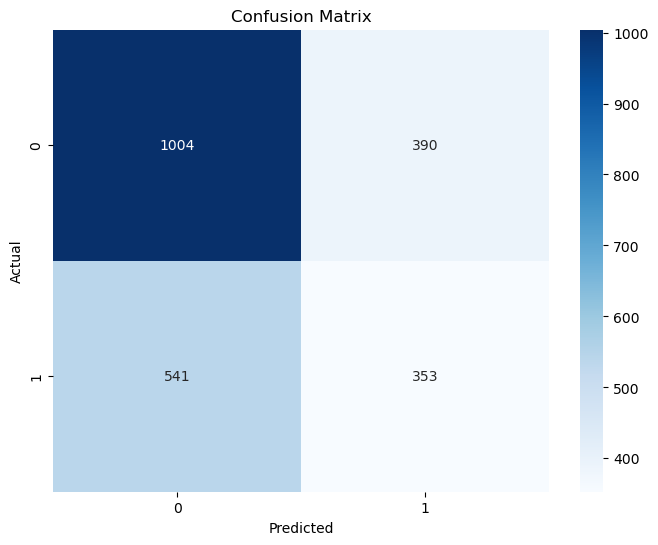

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1394
           1       0.48      0.39      0.43       894

    accuracy                           0.59      2288
   macro avg       0.56      0.56      0.56      2288
weighted avg       0.58      0.59      0.58      2288

Precision Score: 0.47510094212651416


In [315]:
# Step 4: Model Evaluation
# Prepare test data
test_data = prepared_data[prepared_data["date"] > '2021-01-01']
# Evaluate the model's performance on the test data
precision = modeler.evaluate_model(rf_model, test_data, predictors)




In [316]:
#from 100% of data that the model predicted as true positive there are 65% are really true positive
#from 100% of data that are true positive the model predect 72% 

In [317]:

# Step 5: Model Evaluation with Adjusted Threshold
# Adjust the threshold for binary classification and re-evaluate the model
threshold = 0.68  
preds_adjusted = (rf_model.predict_proba(test_data[predictors])[:, 1] > threshold).astype(int)

# Classification Report with Adjusted Threshold
print("Classification Report with Adjusted Threshold:")
print(classification_report(test_data["target"], preds_adjusted))

# Precision Score with Adjusted Threshold
precision_adjusted = precision_score(test_data["target"], preds_adjusted)
print(f"Precision Score with Adjusted Threshold: {precision_adjusted}")


Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.62      0.92      0.74      1394
           1       0.51      0.12      0.20       894

    accuracy                           0.61      2288
   macro avg       0.56      0.52      0.47      2288
weighted avg       0.58      0.61      0.53      2288

Precision Score with Adjusted Threshold: 0.5070422535211268


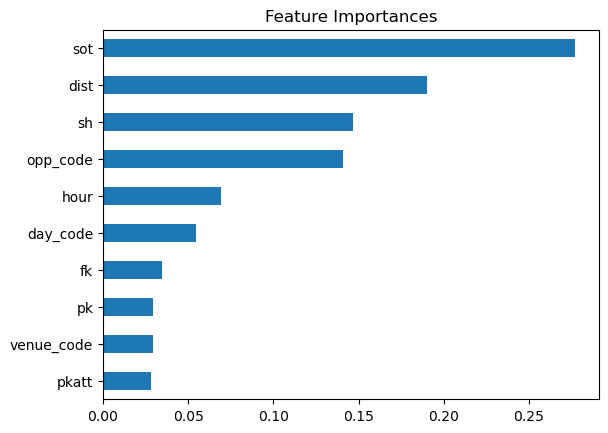

In [318]:
predictors = ["venue_code", "opp_code", "hour", "day_code" ,"sh", "sot" , "dist" , "pk" , "pkatt" , "fk"]
rf_model = modeler.train_model(predictors)

feature_importances = pd.Series(rf_model.feature_importances_, index=predictors)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()

In [319]:
# Select the top 4 features
top_features = feature_importances.nlargest(4).index.tolist()


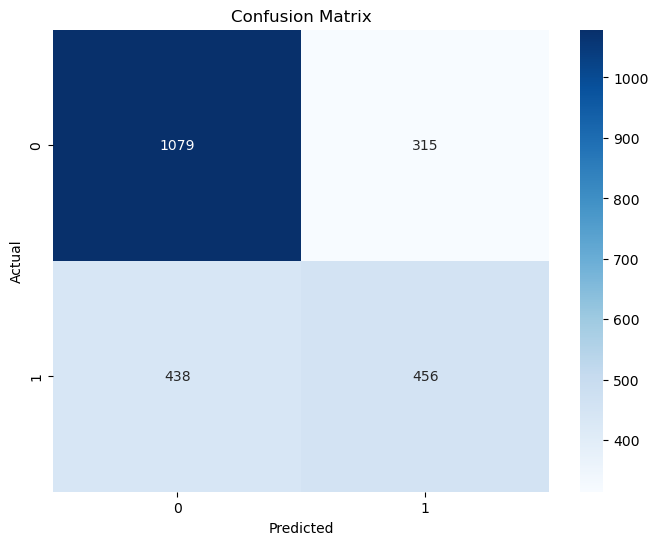

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      1394
           1       0.59      0.51      0.55       894

    accuracy                           0.67      2288
   macro avg       0.65      0.64      0.64      2288
weighted avg       0.66      0.67      0.67      2288

Precision Score: 0.5914396887159533
Precision Score with Selected Features: 0.5914396887159533


In [320]:
# Train a new model with the selected features
selected_rf_model = modeler.train_model(top_features)

# Evaluate the new model on the testing set
precision_selected = modeler.evaluate_model(selected_rf_model, test_data, top_features)
print(f"Precision Score with Selected Features: {precision_selected}")


In [323]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [324]:
cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
new_cols = [f"{c}_rolling" for c in cols]


In [325]:
# Group the data by "team"
grouped_matches = prepared_data.groupby("team")

# Apply rolling averages function to each group
matches_rolling = grouped_matches.apply(lambda x: rolling_averages(x, cols, new_cols))


In [326]:
matches_rolling

date   time            comp         round  \
team                                                                           
Arsenal                 4315 2017-09-09  15:00  Premier League   Matchweek 4   
                        4316 2017-09-17  13:30  Premier League   Matchweek 5   
                        4317 2017-09-25  20:00  Premier League   Matchweek 6   
                        4318 2017-10-01  12:00  Premier League   Matchweek 7   
                        4319 2017-10-14  17:30  Premier League   Matchweek 8   
...                                 ...    ...             ...           ...   
Wolverhampton Wanderers 204  2023-11-11  12:30  Premier League  Matchweek 12   
                        205  2023-11-27  20:00  Premier League  Matchweek 13   
                        206  2023-12-02  15:00  Premier League  Matchweek 14   
                        207  2023-12-05  19:30  Premier League  Matchweek 15   
                        208  2023-12-09  15:00  Premier League  Matchweek 16   

                              day venue result   gf   ga         opponent  \
team                                                                        
Arsenal                 4315  Sat  Home      W  3.0  0.0      Bournemouth   
                        4316  Sun  Away      D  0.0  0.0          Chelsea   
                        4317  Mon  Home      W  2.0  0.0        West Brom   
                        4318  Sun  Home      W  2.0  0.0         Brighton   
                        4319  Sat  Away      L  1.0  2.0          Watford   
...                           ...   ...    ...  ...  ...              ...   
Wolverhampton Wanderers 204   Sat  Home      W  2.0  1.0        Tottenham   
                        205   Mon  Away      L  2.0  3.0           Fulham   
                        206   Sat  Away      L  1.0  2.0          Arsenal   
                        207   Tue  Home      W  1.0  0.0          Burnley   
                        208   Sat  Home      D  1.0  1.0  Nott'ham Forest   

                              ...  hour  day_code  gf_rolling  ga_rolling  \
team                          ...                                           
Arsenal                 4315  ...    15         5    1.333333    2.666667   
                        4316  ...    13         6    1.000000    1.666667   
                        4317  ...    20         0    1.000000    1.333333   
                        4318  ...    12         6    1.666667    0.000000   
                        4319  ...    17         5    1.333333    0.000000   
...                           ...   ...       ...         ...         ...   
Wolverhampton Wanderers 204   ...    12         5    1.666667    1.666667   
                        205   ...    20         0    1.666667    1.666667   
                        206   ...    15         5    1.666667    2.000000   
                        207   ...    19         1    1.666667    2.000000   
                        208   ...    15         5    1.333333    1.666667   

                             sh_rolling sot_rolling dist_rolling fk_rolling  \
team                                                                          
Arsenal                 4315  17.666667    5.333333    18.133333   0.000000   
                        4316  14.333333    5.000000    16.766667   0.333333   
                        4317  12.000000    3.666667    16.566667   0.333333   
                        4318  14.333333    5.333333    17.400000   1.333333   
                        4319  17.000000    5.000000    18.333333   1.666667   
...                                 ...         ...          ...        ...   
Wolverhampton Wanderers 204   14.000000    5.333333    16.966667   0.666667   
                        205   12.666667    4.333333    17.733333   0.666667   
                        206   12.000000    4.000000    17.533333   0.333333   
                        207   10.666667    4.000000    15.300000   0.000000   
                        208    7.333333   

In [327]:
matches_rolling = matches_rolling.droplevel("team")


In [328]:
matches_rolling

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,hour,day_code,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
4315,2017-09-09,15:00,Premier League,Matchweek 4,Sat,Home,W,3.0,0.0,Bournemouth,...,15,5,1.333333,2.666667,17.666667,5.333333,18.133333,0.000000,0.000000,0.000000
4316,2017-09-17,13:30,Premier League,Matchweek 5,Sun,Away,D,0.0,0.0,Chelsea,...,13,6,1.000000,1.666667,14.333333,5.000000,16.766667,0.333333,0.000000,0.000000
4317,2017-09-25,20:00,Premier League,Matchweek 6,Mon,Home,W,2.0,0.0,West Brom,...,20,0,1.000000,1.333333,12.000000,3.666667,16.566667,0.333333,0.000000,0.000000
4318,2017-10-01,12:00,Premier League,Matchweek 7,Sun,Home,W,2.0,0.0,Brighton,...,12,6,1.666667,0.000000,14.333333,5.333333,17.400000,1.333333,0.333333,0.333333
4319,2017-10-14,17:30,Premier League,Matchweek 8,Sat,Away,L,1.0,2.0,Watford,...,17,5,1.333333,0.000000,17.000000,5.000000,18.333333,1.666667,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2023-11-11,12:30,Premier League,Matchweek 12,Sat,Home,W,2.0,1.0,Tottenham,...,12,5,1.666667,1.666667,14.000000,5.333333,16.966667,0.666667,0.000000,0.000000
205,2023-11-27,20:00,Premier League,Matchweek 13,Mon,Away,L,2.0,3.0,Fulham,...,20,0,1.666667,1.666667,12.666667,4.333333,17.733333,0.666667,0.000000,0.000000
206,2023-12-02,15:00,Premier League,Matchweek 14,Sat,Away,L,1.0,2.0,Arsenal,...,15,5,1.666667,2.000000,12.000000,4.000000,17.533333,0.333333,0.333333,0.333333
207,2023-12-05,19:30,Premier League,Matchweek 15,Tue,Home,W,1.0,0.0,Burnley,...,19,1,1.666667,2.000000,10.666667,4.000000,15.300000,0.000000,0.333333,0.333333


In [329]:
matches_rolling.index = range(matches_rolling.shape[0])


In [330]:
matches_rolling

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,hour,day_code,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
0,2017-09-09,15:00,Premier League,Matchweek 4,Sat,Home,W,3.0,0.0,Bournemouth,...,15,5,1.333333,2.666667,17.666667,5.333333,18.133333,0.000000,0.000000,0.000000
1,2017-09-17,13:30,Premier League,Matchweek 5,Sun,Away,D,0.0,0.0,Chelsea,...,13,6,1.000000,1.666667,14.333333,5.000000,16.766667,0.333333,0.000000,0.000000
2,2017-09-25,20:00,Premier League,Matchweek 6,Mon,Home,W,2.0,0.0,West Brom,...,20,0,1.000000,1.333333,12.000000,3.666667,16.566667,0.333333,0.000000,0.000000
3,2017-10-01,12:00,Premier League,Matchweek 7,Sun,Home,W,2.0,0.0,Brighton,...,12,6,1.666667,0.000000,14.333333,5.333333,17.400000,1.333333,0.333333,0.333333
4,2017-10-14,17:30,Premier League,Matchweek 8,Sat,Away,L,1.0,2.0,Watford,...,17,5,1.333333,0.000000,17.000000,5.000000,18.333333,1.666667,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4787,2023-11-11,12:30,Premier League,Matchweek 12,Sat,Home,W,2.0,1.0,Tottenham,...,12,5,1.666667,1.666667,14.000000,5.333333,16.966667,0.666667,0.000000,0.000000
4788,2023-11-27,20:00,Premier League,Matchweek 13,Mon,Away,L,2.0,3.0,Fulham,...,20,0,1.666667,1.666667,12.666667,4.333333,17.733333,0.666667,0.000000,0.000000
4789,2023-12-02,15:00,Premier League,Matchweek 14,Sat,Away,L,1.0,2.0,Arsenal,...,15,5,1.666667,2.000000,12.000000,4.000000,17.533333,0.333333,0.333333,0.333333
4790,2023-12-05,19:30,Premier League,Matchweek 15,Tue,Home,W,1.0,0.0,Burnley,...,19,1,1.666667,2.000000,10.666667,4.000000,15.300000,0.000000,0.333333,0.333333


In [331]:
# Reinitialize the FootballDataModeler instance with the matches_rolling data
modeler = FootballDataModeler(matches_rolling)
predictors = ["venue_code", "opp_code", "hour", "day_code"]

# Training the model
rf_model = modeler.train_model(predictors + new_cols)
rf_model

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

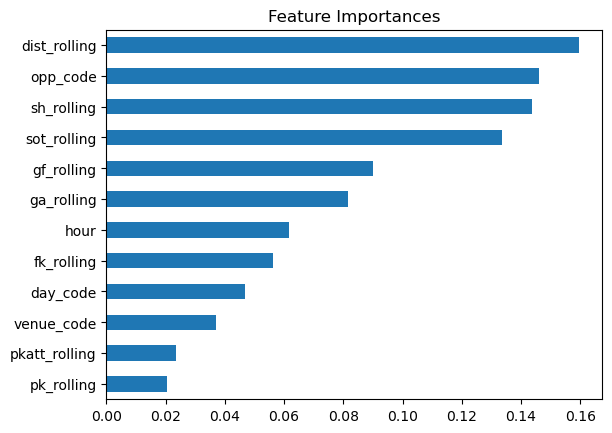

In [332]:
#####
predictors = ["venue_code", "opp_code", "hour", "day_code"]
rf_model = modeler.train_model(predictors+ new_cols)

feature_importances = pd.Series(rf_model.feature_importances_, index=predictors+ new_cols)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()

C:\Users\Aziz il patal\AppData\Local\Temp\ipykernel_6636\401709131.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_data = matches_rolling[prepared_data["date"] > '2021-01-01']


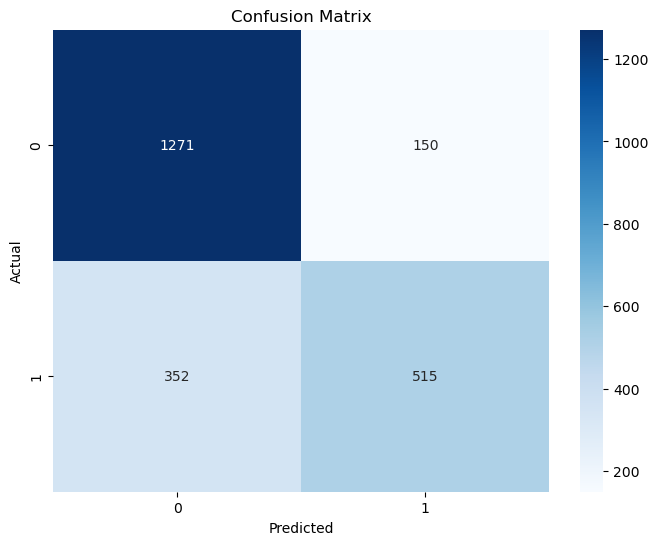

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.84      1421
           1       0.77      0.59      0.67       867

    accuracy                           0.78      2288
   macro avg       0.78      0.74      0.75      2288
weighted avg       0.78      0.78      0.77      2288

Precision Score: 0.7744360902255639


In [333]:
#Model Evaluation
# Prepare test data
test_data = matches_rolling[prepared_data["date"] > '2021-01-01']
# Evaluate the model's performance on the test data
precision = modeler.evaluate_model(rf_model, test_data, predictors + new_cols)




In [334]:
new_data_subset = matches_rolling[["venue_code", "opp_code", "hour", "day_code", "gf_rolling" , "ga_rolling", "sh_rolling", "sot_rolling" , "dist_rolling" , "fk_rolling" , "pk_rolling" , "pkatt_rolling"]]

# Make predictions using the trained model
predictions = rf_model.predict(new_data_subset)
print(list(predictions[:20]))
print("###")
print(list(test_data["target"].head(20)))

[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
###
[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]


In [335]:
new_data_subset

,venue_code,opp_code,hour,day_code,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
0,1,2,15,5,1.333333,2.666667,17.666667,5.333333,18.133333,0.000000,0.000000,0.000000
1,0,7,13,6,1.000000,1.666667,14.333333,5.000000,16.766667,0.333333,0.000000,0.000000
2,1,27,20,0,1.000000,1.333333,12.000000,3.666667,16.566667,0.333333,0.000000,0.000000
3,1,4,12,6,1.666667,0.000000,14.333333,5.333333,17.400000,1.333333,0.333333,0.333333
4,0,26,17,5,1.333333,0.000000,17.000000,5.000000,18.333333,1.666667,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
4787,1,25,12,5,1.666667,1.666667,14.000000,5.333333,16.966667,0.666667,0.000000,0.000000
4788,0,10,20,0,1.666667,1.666667,12.666667,4.333333,17.733333,0.666667,0.000000,0.000000
4789,0,0,15,5,1.666667,2.000000,12.000000,4.000000,17.533333,0.333333,0.333333,0.333333
4790,1,5,19,1,1.666667,2.000000,10.666667,4.000000,15.300000,0.000000,0.333333,0.333333


In [336]:
teams_predictions = pd.DataFrame({
    'date': matches_rolling['date'],
    'team': matches_rolling['team'],
    'opponent': matches_rolling['opponent'],
    'actual_result': matches_rolling['result'],
    'predicted_result': predictions
})

# Map the prediction values to 'Win' and 'Loss'
teams_predictions['predicted_result'] = teams_predictions['predicted_result'].map({1: 'Win', 0: 'Loss'})

# Display the results
print(teams_predictions[['date', 'team', 'opponent', 'actual_result', 'predicted_result']])


           date                     team         opponent actual_result  \
0    2017-09-09                  Arsenal      Bournemouth             W   
1    2017-09-17                  Arsenal          Chelsea             D   
2    2017-09-25                  Arsenal        West Brom             W   
3    2017-10-01                  Arsenal         Brighton             W   
4    2017-10-14                  Arsenal          Watford             L   
...         ...                      ...              ...           ...   
4787 2023-11-11  Wolverhampton Wanderers        Tottenham             W   
4788 2023-11-27  Wolverhampton Wanderers           Fulham             L   
4789 2023-12-02  Wolverhampton Wanderers          Arsenal             L   
4790 2023-12-05  Wolverhampton Wanderers          Burnley             W   
4791 2023-12-09  Wolverhampton Wanderers  Nott'ham Forest             D   

     predicted_result  
0                 Win  
1                Loss  
2                Loss  
3  